In [1]:
%matplotlib notebook

In [2]:
import networkx as nx
import numpy as np
import matplotlib as mpl
import pandas as pd
import seaborn as sns

from scipy import sparse
from scipy.sparse import csr_matrix

from matplotlib import pyplot as plt
from scipy.linalg import eigh as scipy_eigh
from numpy.linalg import eigh as numpy_eigh

from mixing_result_helpers import (
    load_example_graphs, Ut, init_p0, flatten, get_relevant_matrices,
)    

In [3]:
barbell_graph, line_graph, lattice, complete_graph = load_example_graphs()

In [4]:
def get_Ct_list(Wl, sock, p0, alpha, k=100, step=1):
    p_cur = p0

    C_t_list = []
    for i in range(0, k, step):
        C = np.cumsum(np.sort(flatten(sock @ p_cur))[::-1])
        C_t_list.append(np.asarray([0] + list(C)))
        
        p_cur = alpha * p0 + (1 - alpha) * Wl @ p_cur  # do the PPR        
    return C_t_list

def get_Ut_list(m, phi_G, alpha, k=100, step=1):
    x = np.arange(0, 4 * m+1)

    U_t_list = []

    for t in range(0, k, step):
        Ui = Ut(x, t, m, phi_G, alpha)
        U_t_list.append(Ui)

    return U_t_list

In [12]:
t_min_phi_rows = []
t_max = 5000

for g in [barbell_graph, line_graph, lattice, complete_graph]:
    g_name = g.graph['name']
    
    phi_G = g.graph['phi']
    print('graph = {}, phi_G = {:.2f}'.format(g_name, phi_G))

    graph_display_name = "{}($\phi={:.2f}$)".format(g_name, g.graph['phi'])
    n, m = g.number_of_nodes(), g.number_of_edges()
    Wl, sock = get_relevant_matrices(g)
    p0 = init_p0(g)

    C_t_list = get_Ct_list(Wl, sock, p0, 0, k=t_max)

    for phi in np.linspace(0, 1, 11):
        if phi < g.graph['phi']:
            t_min_phi_rows.append((graph_display_name, phi, None))
            continue
        breaks = False
        U_t_list = get_Ut_list(m, phi, 0, k=t_max)
        for t, (C_t, U_t) in enumerate(zip(C_t_list, U_t_list)):
            assert len(C_t) == len(U_t)
            C_t, U_t = map(np.asarray, [C_t, U_t])
            diff = (U_t - C_t)
            diff[np.absolute(diff) <= 1e-10] = 0
            is_upperbound = np.all(diff >= 0)
            if not is_upperbound:
                t_min_phi_rows.append((graph_display_name, phi, t))
                print('for phi={:.2f}, breaks at t={}'.format(phi, t))
#                 pos = np.nonzero(diff < 0)[0] 
#                 print('breaking x values {}'.format(pos))
#                 print('breaking C_t {}'.format(C_t[pos]))
#                 print('breaking U_t {}'.format(U_t[pos]))
                breaks = True
                break
        if not breaks:
            t_min_phi_rows.append((graph_display_name, phi, None))
            print('for phi={:.2f}, does not break for t <= {}'.format(phi, t_max))

    print()

graph = barbell(8,8), phi_G = 0.02
for phi=0.10, does not break for t <= 5000
for phi=0.20, breaks at t=972
for phi=0.30, breaks at t=326
for phi=0.40, breaks at t=168
for phi=0.50, breaks at t=103
for phi=0.60, breaks at t=70
for phi=0.70, breaks at t=50
for phi=0.80, breaks at t=38
for phi=0.90, breaks at t=29
for phi=1.00, breaks at t=24

graph = line(16), phi_G = 0.07
for phi=0.10, does not break for t <= 5000
for phi=0.20, does not break for t <= 5000
for phi=0.30, does not break for t <= 5000
for phi=0.40, breaks at t=227
for phi=0.50, breaks at t=100
for phi=0.60, breaks at t=58
for phi=0.70, breaks at t=38
for phi=0.80, breaks at t=26
for phi=0.90, breaks at t=19
for phi=1.00, breaks at t=14

graph = lattice(4,4), phi_G = 0.48
for phi=0.50, does not break for t <= 5000
for phi=0.60, does not break for t <= 5000
for phi=0.70, does not break for t <= 5000
for phi=0.80, does not break for t <= 5000
for phi=0.90, does not break for t <= 5000
for phi=1.00, breaks at t=126

graph = c

<IPython.core.display.Javascript object>


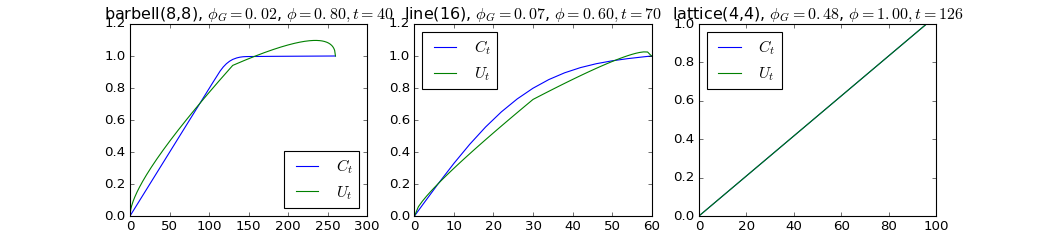

In [15]:
# mpl.rcParams.update(mpl.rcParamsDefault)

breaking_cases = [
    (barbell_graph, 0.8, 40),
    (line_graph, 0.6, 70),
    (lattice, 1.0, 126),
]

fig, axes = plt.subplots(1, 3, figsize=(13, 3))

for i, case in enumerate(breaking_cases):
    ax = axes[i]
    g, breaking_phi, breaking_t = case
    Wl, sock = get_relevant_matrices(g)
    p0 = init_p0(g, seed=0)
    
    C_t = get_Ct_list(Wl, sock, p0, 0, k=breaking_t)[-1]
    U_t = get_Ut_list(g.number_of_edges(), breaking_phi, 0, k=breaking_t)[-1]
    
    ax.plot(C_t)
    ax.plot(U_t)
    ax.legend(['$C_t$', '$U_t$'], loc='best')
    ax.set_title('{}, $\phi_G={:.2f}$, $\phi={:.2f}, t={}$'.format(
        g.graph['name'], g.graph['phi'], breaking_phi, breaking_t)
    )

<IPython.core.display.Javascript object>


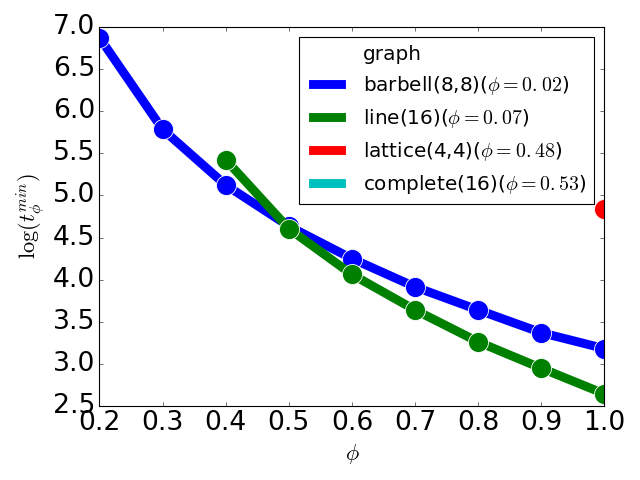

In [16]:
mpl.style.use('paper')

fig, ax = plt.subplots(1, 1)


t_min_phi_df = pd.DataFrame(t_min_phi_rows, columns=['graph', 'phi', 't_min_phi'])
t_min_phi_df['log_t_min_phi'] = np.log(t_min_phi_df['t_min_phi'])
sns.lineplot(
    x='phi',
    y='log_t_min_phi',
    hue='graph',
    data=t_min_phi_df, 
    marker="o", 
    ax=ax
)

ax.set(xlabel='$\phi$', ylabel='$\log(t^{min}_{\phi})$')
fig.tight_layout()
